In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import json
from os.path import expanduser
import sqlite3
import seaborn as sns
import random
from cmcrameri import cm
from matplotlib import colors
import matplotlib.patches as patches

### detections

In [2]:
experiment_name = 'P3856'
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'

EXPERIMENT_DIR = '/media/big-ssd/experiments/{}'.format(experiment_name)

FEATURES_PASEF_DIR = '{}/features-pasef'.format(EXPERIMENT_DIR)
FEATURES_PASEF_FILE = '{}/exp-{}-run-{}-features-pasef-dedup.pkl'.format(FEATURES_PASEF_DIR, experiment_name, run_name)

FEATURES_3DID_DIR = '/media/big-ssd/results-P3856-3did/16-jul-minvi-2500'
# FEATURES_3DID_DIR = '{}/features-3did'.format(EXPERIMENT_DIR)
FEATURES_3DID_FILE = '{}/exp-{}-run-{}-features-3did-dedup.pkl'.format(FEATURES_3DID_DIR, experiment_name, run_name)

FEATURES_MQ_DIR = '{}/features-mq'.format(EXPERIMENT_DIR)
FEATURES_MQ_FILE = '{}/exp-{}-run-{}-features-mq-dedup.pkl'.format(FEATURES_MQ_DIR, experiment_name, run_name)

In [3]:
MAXIMUM_Q_VALUE = 0.01

In [4]:
CONVERTED_DATABASE_NAME = "{}/converted-databases/exp-{}-run-{}-converted.sqlite".format(EXPERIMENT_DIR, experiment_name, run_name)

In [5]:
# only look at this part of the run
RT_LOWER = 1650
RT_UPPER = 2200

In [6]:
# define a straight line to exclude the charge-1 cloud
def scan_coords_for_single_charge_region(mz_lower, mz_upper):
    scan_for_mz_lower = max(int(-1 * ((1.2 * mz_lower) - 1252)), 0)
    scan_for_mz_upper = max(int(-1 * ((1.2 * mz_upper) - 1252)), 0)
    return {'scan_for_mz_lower':scan_for_mz_lower, 'scan_for_mz_upper':scan_for_mz_upper}

#### PASEF-seeded

In [7]:
# load the features detected by PASEF
with open(FEATURES_PASEF_FILE, 'rb') as handle:
    d = pickle.load(handle)
features_pasef_df = d['features_df']

In [8]:
features_pasef_df['excluded'] = features_pasef_df.apply(lambda row: row.scan_lower < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)
features_pasef_df = features_pasef_df[(features_pasef_df.excluded == False)]
features_pasef_df = features_pasef_df[(features_pasef_df.rt_lower >= RT_LOWER) & (features_pasef_df.rt_upper <= RT_UPPER)]

#### 3DID

In [9]:
# load the features detected by 3DID
with open(FEATURES_3DID_FILE, 'rb') as handle:
    d = pickle.load(handle)
features_3did_df = d['features_df']

#### MaxQuant

In [10]:
# load the features detected by MaxQuant
with open(FEATURES_MQ_FILE, 'rb') as handle:
    d = pickle.load(handle)
features_mq_df = d['features_df']

In [11]:
features_mq_df['excluded'] = features_mq_df.apply(lambda row: row.scan_lower < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)
features_mq_df = features_mq_df[(features_mq_df.excluded == False)]
features_mq_df = features_mq_df[(features_mq_df.rt_lower >= RT_LOWER) & (features_mq_df.rt_upper <= RT_UPPER)]
features_mq_df = features_mq_df[(features_mq_df.isotope_count >= 3)].copy()

In [12]:
print('{} features from PASEF, {} features from MaxQuant, {} features from 3DID'.format(len(features_pasef_df), len(features_mq_df), len(features_3did_df)))


69742 features from PASEF, 15070 features from MaxQuant, 53535 features from 3DID


#### consolidate the features from all methods

In [13]:
combined_names = ['feature_id','charge','monoisotopic_mz','scan_apex','rt_apex']

In [14]:
combined_features_mq_df = features_mq_df[combined_names].copy()
combined_features_mq_df['method'] = 'mq'

combined_features_pasef_df = features_pasef_df[combined_names].copy()
combined_features_pasef_df['method'] = 'pasef'

combined_features_3did_df = features_3did_df[combined_names].copy()
combined_features_3did_df['method'] = '3did'

combined_features_df = pd.concat([combined_features_mq_df,combined_features_pasef_df,combined_features_3did_df], axis=0, sort=False, ignore_index=True)
combined_features_df['method_feature_id'] = combined_features_df.method+'-'+combined_features_df.feature_id.astype('str')

#### find the features in common

In [15]:
DUP_MZ_TOLERANCE_PPM = 10
DUP_SCAN_TOLERANCE = 20
DUP_RT_TOLERANCE = 5

In [16]:
# set up dup definitions
MZ_TOLERANCE_PERCENT = DUP_MZ_TOLERANCE_PPM * 10**-4
combined_features_df['dup_mz'] = combined_features_df['monoisotopic_mz']  # shorthand to reduce verbosity
combined_features_df['dup_mz_ppm_tolerance'] = combined_features_df.dup_mz * MZ_TOLERANCE_PERCENT / 100
combined_features_df['dup_mz_lower'] = combined_features_df.dup_mz - combined_features_df.dup_mz_ppm_tolerance
combined_features_df['dup_mz_upper'] = combined_features_df.dup_mz + combined_features_df.dup_mz_ppm_tolerance
combined_features_df['dup_scan_lower'] = combined_features_df.scan_apex - DUP_SCAN_TOLERANCE
combined_features_df['dup_scan_upper'] = combined_features_df.scan_apex + DUP_SCAN_TOLERANCE
combined_features_df['dup_rt_lower'] = combined_features_df.rt_apex - DUP_RT_TOLERANCE
combined_features_df['dup_rt_upper'] = combined_features_df.rt_apex + DUP_RT_TOLERANCE

In [17]:
combined_id = 1
sets_d = {'mq':set(), '3did':set(), 'pasef':set()}
features_processed = set()
for row in combined_features_df.itertuples():
    if row.method_feature_id not in features_processed:
        df = combined_features_df[(row.charge == combined_features_df.charge) & (row.dup_mz >= combined_features_df.dup_mz_lower) & (row.dup_mz <= combined_features_df.dup_mz_upper) & (row.scan_apex >= combined_features_df.dup_scan_lower) & (row.scan_apex <= combined_features_df.dup_scan_upper) & (row.rt_apex >= combined_features_df.dup_rt_lower) & (row.rt_apex <= combined_features_df.dup_rt_upper)].copy()
        if len(df) > 0:
            # remove the features that have already been processed
            feature_ids_not_processed = set(df.method_feature_id.tolist()) - features_processed
            df = df[(df.method_feature_id.isin(feature_ids_not_processed))]
            for method in df.method.tolist():
                sets_d[method].add(combined_id)
            # record the features that have been processed
            features_processed.update(set(df.method_feature_id.tolist()))
            combined_id += 1

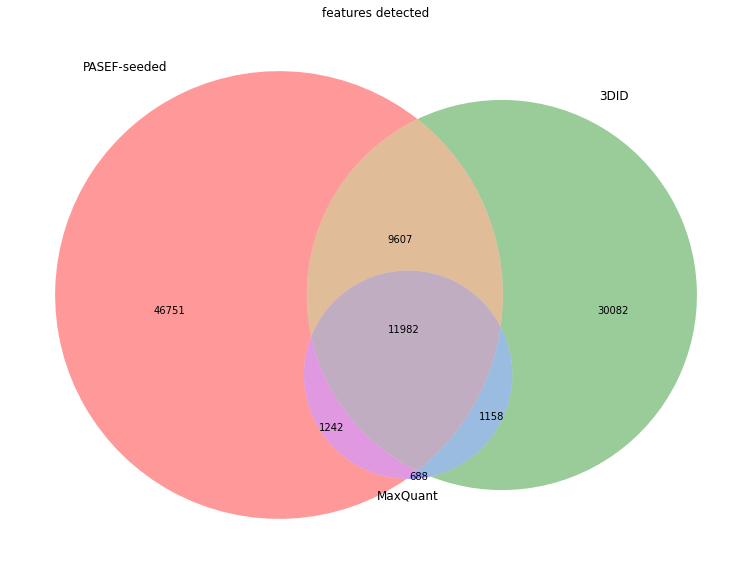

In [18]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

f, ax1 = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('features detected')

venn3([sets_d['pasef'],sets_d['3did'],sets_d['mq']], ('PASEF-seeded','3DID','MaxQuant'))

plt.show()

### identifications

#### PASEF-seeded

In [19]:
IDENTS_PASEF_DIR = '{}/identifications-pasef'.format(EXPERIMENT_DIR)
IDENTS_PASEF_FILE = '{}/exp-{}-identifications-pasef-recalibrated.pkl'.format(IDENTS_PASEF_DIR, experiment_name)

In [20]:
# load the features identified by PASEF
with open(IDENTS_PASEF_FILE, 'rb') as handle:
    d = pickle.load(handle)
idents_pasef_df = d['identifications_df']
idents_pasef_df = idents_pasef_df[(idents_pasef_df.run_name == run_name) & (idents_pasef_df['percolator q-value'] <= MAXIMUM_Q_VALUE)].copy()

In [21]:
idents_pasef_df['excluded'] = idents_pasef_df.apply(lambda row: row.scan_apex < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)
idents_pasef_df = idents_pasef_df[(idents_pasef_df.excluded == False)]

#### MaxQuant

In [22]:
MQ_PERCOLATOR_OUTPUT_DIR = '{}/percolator-output-pasef-maxquant'.format(EXPERIMENT_DIR)

In [23]:
# load the percolator output
MQ_PERCOLATOR_OUTPUT_FILE_NAME = "{}/{}.percolator.target.psms.txt".format(MQ_PERCOLATOR_OUTPUT_DIR, experiment_name)
mq_psms_df = pd.read_csv(MQ_PERCOLATOR_OUTPUT_FILE_NAME, sep='\t')
mq_psms_df.rename(columns={'scan': 'mq_index'}, inplace=True)
mq_psms_df.drop(['charge'], axis=1, inplace=True)
# remove the poor quality identifications
mq_psms_df = mq_psms_df[mq_psms_df['peptide mass'] > 0]

In [24]:
idents_mq_df = pd.merge(features_mq_df, mq_psms_df, how='left', left_on=['mq_index'], right_on=['mq_index'])
# remove any features that were not identified
idents_mq_df.dropna(subset=['sequence'], inplace=True)

In [25]:
idents_mq_df = idents_mq_df[(idents_mq_df.raw_file == run_name) & (idents_mq_df['percolator q-value'] <= MAXIMUM_Q_VALUE)].copy()

In [26]:
idents_mq_df['excluded'] = idents_mq_df.apply(lambda row: row.scan_apex < scan_coords_for_single_charge_region(row.monoisotopic_mz, row.monoisotopic_mz)['scan_for_mz_lower'], axis=1)
idents_mq_df = idents_mq_df[(idents_mq_df.excluded == False)]
idents_mq_df = idents_mq_df[(idents_mq_df.rt_apex >= RT_LOWER) & (idents_mq_df.rt_apex <= RT_UPPER)]
idents_mq_df['feature_intensity'] = idents_mq_df.intensity
idents_mq_df = idents_mq_df[(idents_mq_df.isotope_count >= 3)].copy()

#### consolidate the identifications from all methods

In [27]:
combined_names = ['feature_id','charge','monoisotopic_mz','scan_apex','rt_apex']

In [28]:
combined_idents_mq_df = idents_mq_df[combined_names].copy()
combined_idents_mq_df['method'] = 'mq'

combined_idents_pasef_df = idents_pasef_df[combined_names].copy()
combined_idents_pasef_df['method'] = 'pasef'

combined_idents_3did_df = features_3did_df[combined_names].copy()
combined_idents_3did_df['method'] = '3did'

combined_idents_df = pd.concat([combined_idents_mq_df,combined_idents_pasef_df,combined_idents_3did_df], axis=0, sort=False, ignore_index=True)
combined_idents_df['method_feature_id'] = combined_idents_df.method+'-'+combined_idents_df.feature_id.astype('str')

#### find the identifications in common

In [29]:
# set up dup definitions
MZ_TOLERANCE_PERCENT = DUP_MZ_TOLERANCE_PPM * 10**-4
combined_idents_df['dup_mz'] = combined_idents_df['monoisotopic_mz']  # shorthand to reduce verbosity
combined_idents_df['dup_mz_ppm_tolerance'] = combined_idents_df.dup_mz * MZ_TOLERANCE_PERCENT / 100
combined_idents_df['dup_mz_lower'] = combined_idents_df.dup_mz - combined_idents_df.dup_mz_ppm_tolerance
combined_idents_df['dup_mz_upper'] = combined_idents_df.dup_mz + combined_idents_df.dup_mz_ppm_tolerance
combined_idents_df['dup_scan_lower'] = combined_idents_df.scan_apex - DUP_SCAN_TOLERANCE
combined_idents_df['dup_scan_upper'] = combined_idents_df.scan_apex + DUP_SCAN_TOLERANCE
combined_idents_df['dup_rt_lower'] = combined_idents_df.rt_apex - DUP_RT_TOLERANCE
combined_idents_df['dup_rt_upper'] = combined_idents_df.rt_apex + DUP_RT_TOLERANCE

In [30]:
combined_id = 1
combined_features = []
sets_d = {'mq':set(), '3did':set(), 'pasef':set()}
features_processed = set()
for row in combined_idents_df.itertuples():
    if row.method_feature_id not in features_processed:
        df = combined_idents_df[(row.charge == combined_idents_df.charge) & (row.dup_mz >= combined_idents_df.dup_mz_lower) & (row.dup_mz <= combined_idents_df.dup_mz_upper) & (row.scan_apex >= combined_idents_df.dup_scan_lower) & (row.scan_apex <= combined_idents_df.dup_scan_upper) & (row.rt_apex >= combined_idents_df.dup_rt_lower) & (row.rt_apex <= combined_idents_df.dup_rt_upper)].copy()
        if len(df) > 0:
            # remove the features that have already been processed
            feature_ids_not_processed = set(df.method_feature_id.tolist()) - features_processed
            df = df[(df.method_feature_id.isin(feature_ids_not_processed))]
            for method in df.method.tolist():
                sets_d[method].add(combined_id)
            # record the features that have been processed
            features_processed.update(set(df.method_feature_id.tolist()))
            # separate the method feature ids
            feature_ids = {'3did':0, 'pasef':0, 'mq':0}
            for m in df.method_feature_id.tolist():
                method = m.split('-')[0]
                feature_id = int(m.split('-')[1])
                feature_ids[method] = feature_id
            # store the features that were combined
            combined_features.append({'combined_id':combined_id, 'number_of_methods':len(df.method.unique()), 'methods':list(df.method.unique()), 'method_ids':df.method_feature_id.tolist(), '3did_feature_id':feature_ids['3did'], 'pasef_feature_id':feature_ids['pasef'], 'mq_feature_id':feature_ids['mq']})
            # update the combined feature identifier
            combined_id += 1

In [31]:
combined_features_df = pd.DataFrame(combined_features)
combined_features_df.to_pickle('{}/combined_features_df.pkl'.format(expanduser('~')))

In [32]:
combined_features_df.sample(n=5)

,combined_id,number_of_methods,methods,method_ids,3did_feature_id,pasef_feature_id,mq_feature_id
28979,28980,1,[3did],[3did-81259],81259,0,0
48371,48372,1,[3did],[3did-42306],42306,0,0
2992,2993,2,"[mq, pasef]","[mq-1208403, pasef-4286801]",0,4286801,1208403
40656,40657,1,[3did],[3did-24678],24678,0,0
18809,18810,1,[3did],[3did-79722],79722,0,0


In [33]:
# merge 3DID attributes
combined_features_df = pd.merge(combined_features_df, features_3did_df[['feature_id','prediction','deconvolution_score','feature_intensity']], how='left', left_on=['3did_feature_id'], right_on=['feature_id'])
combined_features_df.rename(columns={'prediction':'3did_prediction', 'deconvolution_score':'3did_deconvolution_score', 'feature_intensity':'3did_feature_intensity'}, inplace=True)
combined_features_df.drop(['feature_id'], axis=1, inplace=True)

In [34]:
# merge PASEF attributes
combined_features_df = pd.merge(combined_features_df, idents_pasef_df[['feature_id','deconvolution_score','feature_intensity']], how='left', left_on=['pasef_feature_id'], right_on=['feature_id'])
combined_features_df.rename(columns={'deconvolution_score':'pasef_deconvolution_score', 'feature_intensity':'pasef_feature_intensity'}, inplace=True)
combined_features_df.drop(['feature_id'], axis=1, inplace=True)

In [35]:
# merge MQ attributes
combined_features_df = pd.merge(combined_features_df, idents_mq_df[['feature_id','feature_intensity']], how='left', left_on=['mq_feature_id'], right_on=['feature_id'])
combined_features_df.rename(columns={'feature_intensity':'mq_feature_intensity'}, inplace=True)
combined_features_df.drop(['feature_id'], axis=1, inplace=True)

In [36]:
combined_features_df['3did_log_intensity'] = np.log10(combined_features_df['3did_feature_intensity'])
combined_features_df['pasef_log_intensity'] = np.log10(combined_features_df.pasef_feature_intensity)
combined_features_df['mq_log_intensity'] = np.log10(combined_features_df.mq_feature_intensity)

In [37]:
combined_features_df.fillna(0, inplace=True)

In [38]:
combined_features_df.sample(n=3)

,combined_id,number_of_methods,methods,method_ids,3did_feature_id,pasef_feature_id,mq_feature_id,3did_prediction,3did_deconvolution_score,3did_feature_intensity,pasef_deconvolution_score,pasef_feature_intensity,mq_feature_intensity,3did_log_intensity,pasef_log_intensity,mq_log_intensity
44871,44872,1,[3did],[3did-85279],85279,0,0,0.699274,266.080314,1091.0,0.000000,0.0,0.0,3.037825,0.000000,0.0
7696,7697,2,"[pasef, 3did]","[pasef-3385302, 3did-119836]",119836,3385302,0,0.781337,369.123887,3839.0,433.453443,3791.0,0.0,3.584218,3.578754,0.0
40684,40685,1,[3did],[3did-100049],100049,0,0,0.723004,313.476369,1282.0,0.000000,0.0,0.0,3.107888,0.000000,0.0


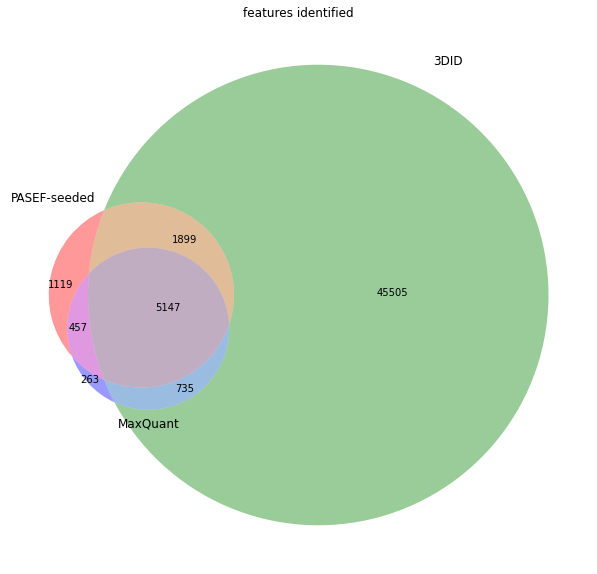

In [39]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

f, ax1 = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('features identified')

venn3([sets_d['pasef'],sets_d['3did'],sets_d['mq']], ('PASEF-seeded','3DID','MaxQuant'))

plt.show()

#### analyse features that were only identified by the PASEF-seeded method

In [40]:
combined_id_pasef_only = sets_d['pasef']-sets_d['mq']-sets_d['3did']

In [41]:
combined_features_df[(combined_features_df.combined_id.isin(combined_id_pasef_only))].sort_values(by=['pasef_feature_intensity'], ascending=False, inplace=False).head(n=3)

,combined_id,number_of_methods,methods,method_ids,3did_feature_id,pasef_feature_id,mq_feature_id,3did_prediction,3did_deconvolution_score,3did_feature_intensity,pasef_deconvolution_score,pasef_feature_intensity,mq_feature_intensity,3did_log_intensity,pasef_log_intensity,mq_log_intensity
7340,7341,1,[pasef],[pasef-3893001],0,3893001,0,0.0,0.0,0.0,510.085384,94354.0,0.0,0.0,4.974760,0.0
6760,6761,1,[pasef],[pasef-2272901],0,2272901,0,0.0,0.0,0.0,871.705628,81368.0,0.0,0.0,4.910454,0.0
6868,6869,1,[pasef],[pasef-4030601],0,4030601,0,0.0,0.0,0.0,718.467985,79650.0,0.0,0.0,4.901186,0.0


In [42]:
pasef_feature = features_pasef_df[(features_pasef_df.feature_id == 3893001)].iloc[0]
pasef_feature

mono_mz_lower                                                                    1094.999828
mono_mz_upper                                                                    1095.069581
scan_apex                                                                               95.0
scan_lower                                                                                60
scan_upper                                                                               133
rt_apex                                                                          2114.067227
rt_lower                                                                         2111.420824
rt_upper                                                                         2117.242239
intensity_without_saturation_correction                                                61065
intensity_with_saturation_correction                                                   94354
mono_intensity_adjustment_outcome                            monoisoto

In [43]:
rt_df = pd.DataFrame(pasef_feature.rt_df)

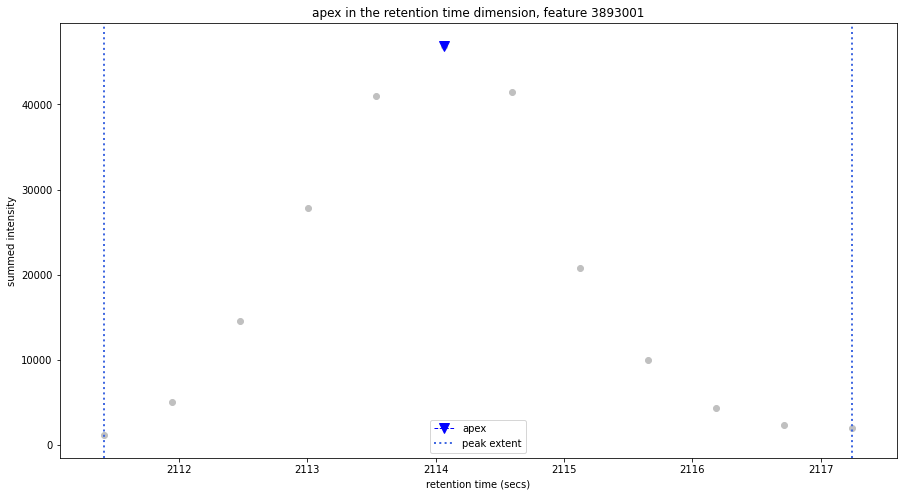

In [44]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the flattened points
plt.scatter(rt_df.retention_time_secs, rt_df.intensity, c='silver')

plt.plot(pasef_feature.rt_apex, rt_df[rt_df.retention_time_secs==pasef_feature.rt_apex].intensity, marker='v', color='blue', linestyle='--', linewidth=1, ms=10, label='apex')

plt.axvline(x=pasef_feature.rt_lower, linestyle=':', color='royalblue', linewidth=2, label='peak extent')
plt.axvline(x=pasef_feature.rt_upper, linestyle=':', color='royalblue', linewidth=2)

plt.title('apex in the retention time dimension, feature {}'.format(pasef_feature.feature_id))
plt.legend()
plt.xlabel("retention time (secs)")
plt.ylabel("summed intensity")
plt.show()

#### isotope extent in mobility

In [45]:
scan_df = pd.DataFrame(pasef_feature.scan_df)

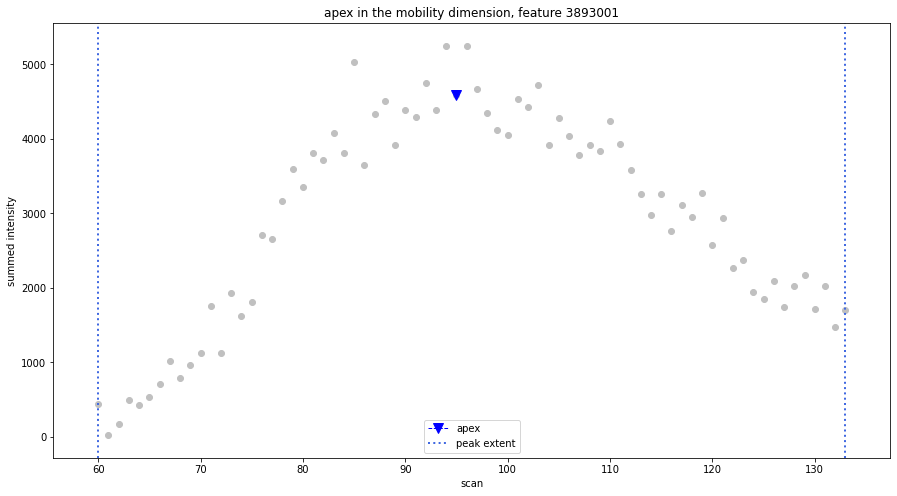

In [46]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

# plot the flattened points
plt.scatter(scan_df.scan, scan_df.intensity, c='silver')

plt.plot(pasef_feature.scan_apex, scan_df[scan_df.scan==pasef_feature.scan_apex].intensity, marker='v', color='blue', linestyle='--', linewidth=1, ms=10, label='apex')

plt.axvline(x=pasef_feature.scan_lower, linestyle=':', color='royalblue', linewidth=2, label='peak extent')
plt.axvline(x=pasef_feature.scan_upper, linestyle=':', color='royalblue', linewidth=2)

plt.title('apex in the mobility dimension, feature {}'.format(pasef_feature.feature_id))
plt.legend()
plt.xlabel("scan")
plt.ylabel("summed intensity")
plt.show()

#### feature region at its RT apex

In [47]:
# create the colour map to convert intensity to colour
colour_map = cm.batlow_r
norm = colors.LogNorm(vmin=100, vmax=1000, clip=True)

In [48]:
feature_mz_lower = json.loads(pasef_feature.envelope)[0][0]
feature_mz_upper = json.loads(pasef_feature.envelope)[-1][0]
feature_scan_lower = pasef_feature.scan_lower
feature_scan_upper = pasef_feature.scan_upper
feature_rt_lower = pasef_feature.rt_apex - 1
feature_rt_upper = pasef_feature.rt_apex + 1

In [49]:
mz_lower = feature_mz_lower - 1
mz_upper = feature_mz_upper + 1
scan_lower = feature_scan_lower - 20
scan_upper = feature_scan_upper + 20
rt_lower = feature_rt_lower
rt_upper = feature_rt_upper

In [50]:
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
raw_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where frame_type == 0 and retention_time_secs >= {} and retention_time_secs <= {} and scan >= {} and scan <= {} and mz >= {} and mz <= {}".format(rt_lower, rt_upper, scan_lower, scan_upper, mz_lower, mz_upper), db_conn)
db_conn.close()

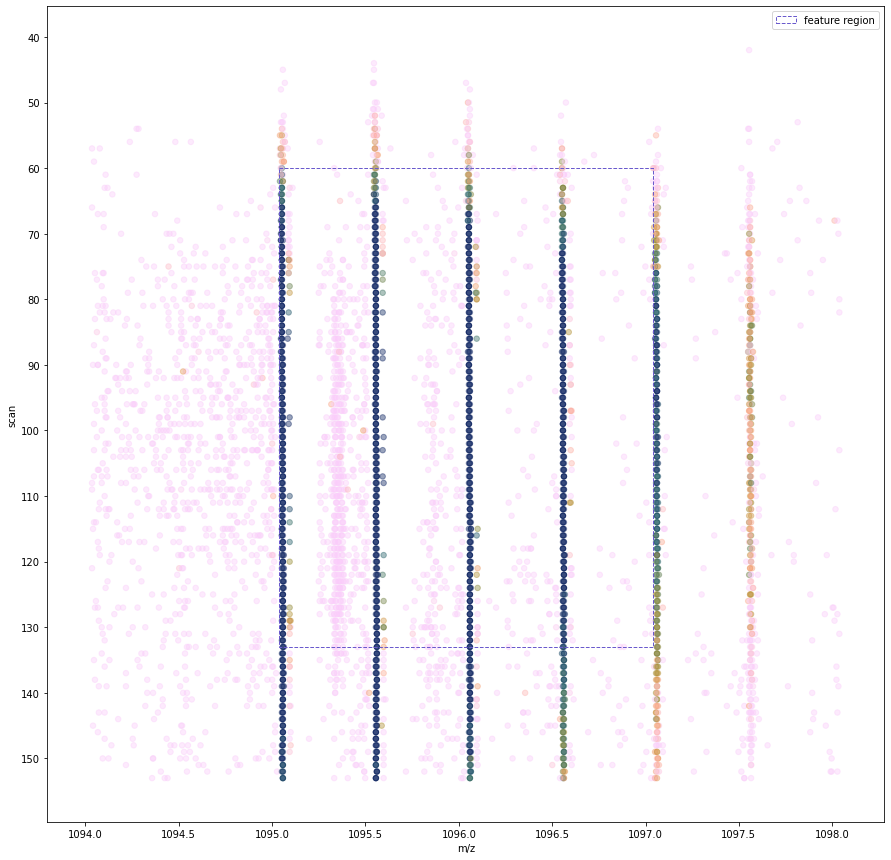

In [51]:
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(raw_df.mz, raw_df.scan, c=raw_df.intensity, cmap=colour_map, norm=norm, alpha=0.4, s=30, linewidths=None, edgecolors=None)

# draw the feature region
top_left = (feature_mz_lower,feature_scan_lower)
width = feature_mz_upper - feature_mz_lower
height = feature_scan_upper - feature_scan_lower
cuboid_rect = patches.Rectangle(top_left,width,height,linewidth=1.0,linestyle='--',edgecolor='slateblue',facecolor='none',label='feature region')
ax1.add_patch(cuboid_rect)

plt.xlabel("m/z")
plt.ylabel("scan")

nearest = 0.5
range_l = round(raw_df.mz.min() / nearest) * nearest
range_u = round(raw_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

nearest = 10.0
range_l = round(raw_df.scan.min() / nearest) * nearest
range_u = round(raw_df.scan.max() / nearest) * nearest
plt.yticks(np.arange(range_l,range_u+nearest,nearest))

# plt.title('feature region around the voxel\'s midpoint, feature {}, RT {} secs'.format(selected_feature.feature_id, round(selected_feature.voxel_metadata_d['voxel_rt_midpoint'],1)))

plt.legend()
plt.gca().invert_yaxis()
plt.show()

In [52]:
raw_df['normalised_intensity'] = raw_df.intensity / raw_df.intensity.max()

In [53]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Rescale to values between 0 and 1
tableau20_mpl = tableau20.copy()
for i in range(len(tableau20_mpl)):  
    r, g, b = tableau20_mpl[i]  
    tableau20_mpl[i] = (r / 255., g / 255., b / 255.)

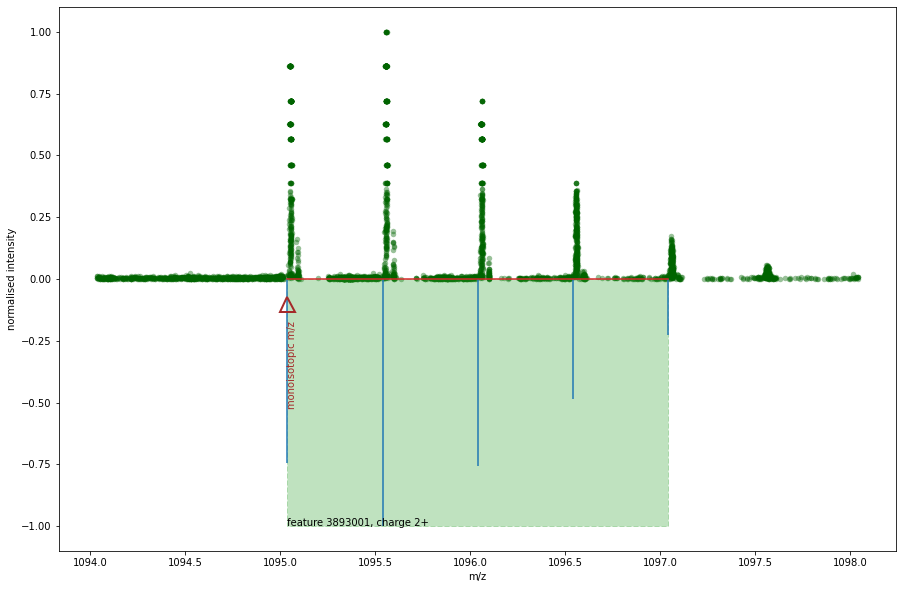

In [56]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

# plot the raw data
ax.scatter(raw_df.mz, raw_df.normalised_intensity, marker='o', color='darkgreen', lw=0, s=30, alpha=0.4)

# plot the feature's bounding rectangle
envelope = json.loads(pasef_feature.envelope)
env_width = envelope[-1][0] - envelope[0][0]
rect_colour = tableau20_mpl[4]
rect = patches.Rectangle((envelope[0][0],0),env_width,-1.0,linewidth=1,linestyle=(0,(5,2)),edgecolor=rect_colour+(0.3,),facecolor=rect_colour+(0.3,),fill=True)
ax.add_patch(rect)
ax.text(x=envelope[0][0], y=-1.0, s='feature {}, charge {}+'.format(pasef_feature.feature_id, pasef_feature.charge))

# determine the peaks from the envelope
envelope_df = pd.DataFrame(envelope, columns=['mz','intensity'])
envelope_df['normalised_intensity'] = envelope_df.intensity / envelope_df.intensity.max()

# plot the peaks from deconvolution
markerline, stemlines, baseline = ax.stem(envelope_df.mz, -envelope_df.normalised_intensity, markerfmt=" ", use_line_collection=True)

# show the monoisotopic m/z determined by deconvolution
ax.plot(pasef_feature.monoisotopic_mz, -0.1, marker='^', markerfacecolor='none', markeredgecolor='brown', linestyle='', markeredgewidth=2, ms=15)
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax.text(pasef_feature.monoisotopic_mz, -0.35, "monoisotopic m/z", **text_style, rotation='vertical')

nearest = 0.5
range_l = round(raw_df.mz.min() / nearest) * nearest
range_u = round(raw_df.mz.max() / nearest) * nearest
ax.set_xticks(np.arange(range_l,range_u+nearest,nearest))

ax.set_xlabel('m/z')
ax.set_ylabel('normalised intensity')

# ax.set_title('spectra for feature {}, monoisotopic peak at {} m/z, charge {}+, deconvolution score: {}'.format(selected_feature.feature_id, round(selected_feature.mono_mz,4), selected_feature.charge, round(selected_feature.deconvolution_score,1)))

plt.show()

#### analyse features that were only identified by MaxQuant

In [57]:
combined_id_mq_only = sets_d['mq']-sets_d['3did']-sets_d['pasef']

In [58]:
combined_features_df[(combined_features_df.combined_id.isin(combined_id_mq_only))].sort_values(by=['mq_feature_intensity'], ascending=False, inplace=False).head(n=5)

,combined_id,number_of_methods,methods,method_ids,3did_feature_id,pasef_feature_id,mq_feature_id,3did_prediction,3did_deconvolution_score,3did_feature_intensity,pasef_deconvolution_score,pasef_feature_intensity,mq_feature_intensity,3did_log_intensity,pasef_log_intensity,mq_log_intensity
3921,3922,1,[mq],[mq-1215417],0,0,1215417,0.0,0.0,0.0,0.0,0.0,2230700.0,0.0,0.0,6.348441
3450,3451,1,[mq],[mq-1211909],0,0,1211909,0.0,0.0,0.0,0.0,0.0,1626800.0,0.0,0.0,6.211334
5277,5278,1,[mq],[mq-1222822],0,0,1222822,0.0,0.0,0.0,0.0,0.0,1239400.0,0.0,0.0,6.093211
4125,4126,1,[mq],[mq-1216140],0,0,1216140,0.0,0.0,0.0,0.0,0.0,472380.0,0.0,0.0,5.674292
5303,5304,1,[mq],[mq-1222757],0,0,1222757,0.0,0.0,0.0,0.0,0.0,435440.0,0.0,0.0,5.638928


In [59]:
mq_feature = features_mq_df[(features_mq_df.feature_id == 1222757)].iloc[0]
mq_feature

feature_id                                                     1222757
monoisotopic_mass                                            2276.0297
charge                                                               2
monoisotopic_mz                                              1139.0221
intensity                                                       435440
scan_apex                                                          132
scan_lower                                                        81.0
scan_upper                                                       183.0
rt_apex                                                         2148.0
rt_lower                                                      2147.916
rt_upper                                                      2148.084
raw_file                                 P3856_YHE211_1_Slot1-1_1_5104
envelope                 [[1139.0221, 0.0], [1140.5271324999999, 0.0]]
isotope_count                                                        3
mq_ind

#### feature region at its RT apex

In [60]:
# create the colour map to convert intensity to colour
colour_map = cm.batlow_r
norm = colors.LogNorm(vmin=100, vmax=1000, clip=True)

In [61]:
feature_mz_lower = json.loads(mq_feature.envelope)[0][0]
feature_mz_upper = json.loads(mq_feature.envelope)[-1][0]
feature_scan_lower = mq_feature.scan_lower
feature_scan_upper = mq_feature.scan_upper
feature_rt_lower = mq_feature.rt_apex - 1
feature_rt_upper = mq_feature.rt_apex + 1

In [62]:
mz_lower = feature_mz_lower - 1
mz_upper = feature_mz_upper + 1
scan_lower = feature_scan_lower - 20
scan_upper = feature_scan_upper + 20
rt_lower = feature_rt_lower
rt_upper = feature_rt_upper

In [63]:
db_conn = sqlite3.connect(CONVERTED_DATABASE_NAME)
raw_df = pd.read_sql_query("select frame_id,mz,scan,intensity,retention_time_secs from frames where frame_type == 0 and retention_time_secs >= {} and retention_time_secs <= {} and scan >= {} and scan <= {} and mz >= {} and mz <= {}".format(rt_lower, rt_upper, scan_lower, scan_upper, mz_lower, mz_upper), db_conn)
db_conn.close()

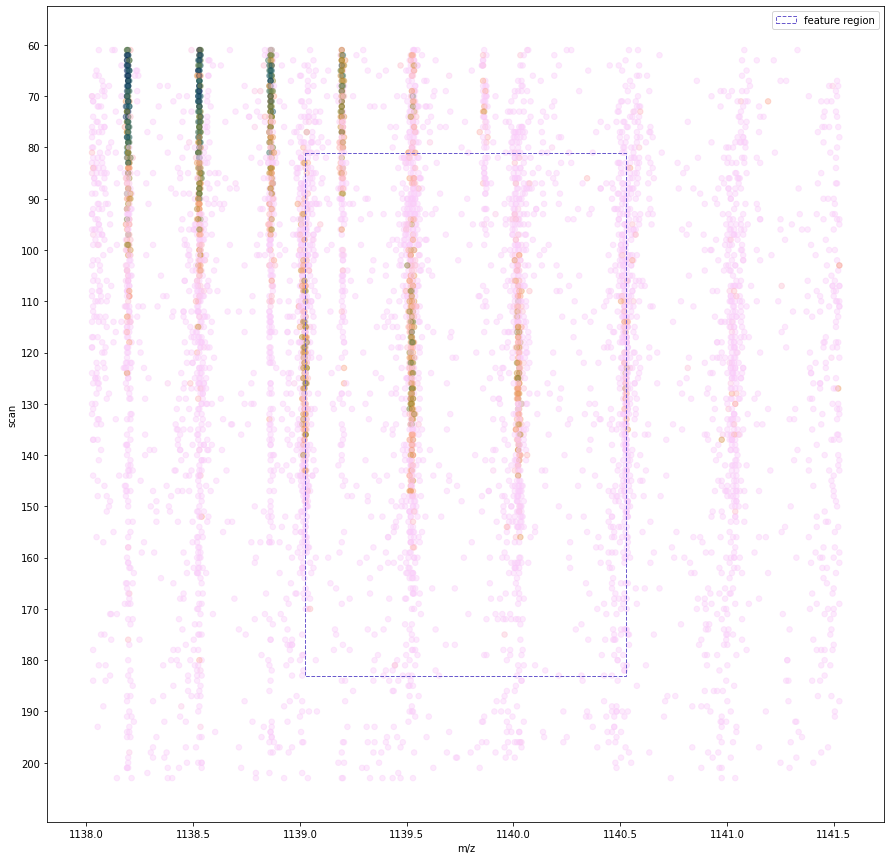

In [64]:
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(raw_df.mz, raw_df.scan, c=raw_df.intensity, cmap=colour_map, norm=norm, alpha=0.4, s=30, linewidths=None, edgecolors=None)

# draw the feature region
top_left = (feature_mz_lower,feature_scan_lower)
width = feature_mz_upper - feature_mz_lower
height = feature_scan_upper - feature_scan_lower
cuboid_rect = patches.Rectangle(top_left,width,height,linewidth=1.0,linestyle='--',edgecolor='slateblue',facecolor='none',label='feature region')
ax1.add_patch(cuboid_rect)

plt.xlabel("m/z")
plt.ylabel("scan")

nearest = 0.5
range_l = round(raw_df.mz.min() / nearest) * nearest
range_u = round(raw_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

nearest = 10.0
range_l = round(raw_df.scan.min() / nearest) * nearest
range_u = round(raw_df.scan.max() / nearest) * nearest
plt.yticks(np.arange(range_l,range_u+nearest,nearest))

# plt.title('feature region around the voxel\'s midpoint, feature {}, RT {} secs'.format(selected_feature.feature_id, round(selected_feature.voxel_metadata_d['voxel_rt_midpoint'],1)))

plt.legend()
plt.gca().invert_yaxis()
plt.show()

In [65]:
raw_df['normalised_intensity'] = raw_df.intensity / raw_df.intensity.max()

In [66]:
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Rescale to values between 0 and 1
tableau20_mpl = tableau20.copy()
for i in range(len(tableau20_mpl)):  
    r, g, b = tableau20_mpl[i]  
    tableau20_mpl[i] = (r / 255., g / 255., b / 255.)

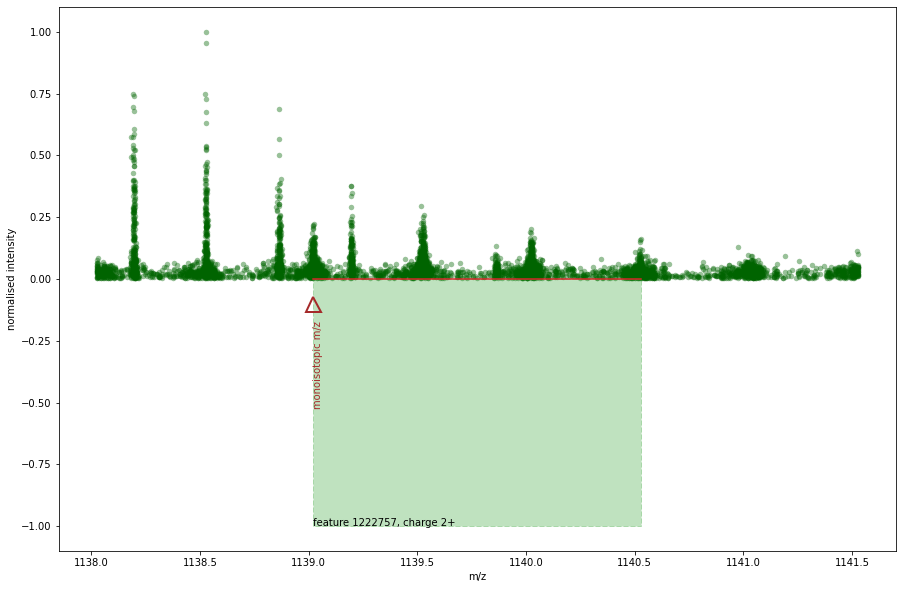

In [67]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

# plot the raw data
ax.scatter(raw_df.mz, raw_df.normalised_intensity, marker='o', color='darkgreen', lw=0, s=30, alpha=0.4)

# plot the feature's bounding rectangle
envelope = json.loads(mq_feature.envelope)
env_width = envelope[-1][0] - envelope[0][0]
rect_colour = tableau20_mpl[4]
rect = patches.Rectangle((envelope[0][0],0),env_width,-1.0,linewidth=1,linestyle=(0,(5,2)),edgecolor=rect_colour+(0.3,),facecolor=rect_colour+(0.3,),fill=True)
ax.add_patch(rect)
ax.text(x=envelope[0][0], y=-1.0, s='feature {}, charge {}+'.format(mq_feature.feature_id, mq_feature.charge))

# determine the peaks from the envelope
envelope_df = pd.DataFrame(envelope, columns=['mz','intensity'])
envelope_df['normalised_intensity'] = envelope_df.intensity / envelope_df.intensity.max()

# plot the peaks from deconvolution
markerline, stemlines, baseline = ax.stem(envelope_df.mz, -envelope_df.normalised_intensity, markerfmt=" ", use_line_collection=True)

# show the monoisotopic m/z determined by deconvolution
ax.plot(mq_feature.monoisotopic_mz, -0.1, marker='^', markerfacecolor='none', markeredgecolor='brown', linestyle='', markeredgewidth=2, ms=15)
text_style = dict(size=10, color='brown', verticalalignment='center', horizontalalignment='left')
ax.text(mq_feature.monoisotopic_mz, -0.35, "monoisotopic m/z", **text_style, rotation='vertical')

nearest = 0.5
range_l = round(raw_df.mz.min() / nearest) * nearest
range_u = round(raw_df.mz.max() / nearest) * nearest
ax.set_xticks(np.arange(range_l,range_u+nearest,nearest))

ax.set_xlabel('m/z')
ax.set_ylabel('normalised intensity')

# ax.set_title('spectra for feature {}, monoisotopic peak at {} m/z, charge {}+, deconvolution score: {}'.format(selected_feature.feature_id, round(selected_feature.mono_mz,4), selected_feature.charge, round(selected_feature.deconvolution_score,1)))

plt.show()

#### analyse other attributes of features in common

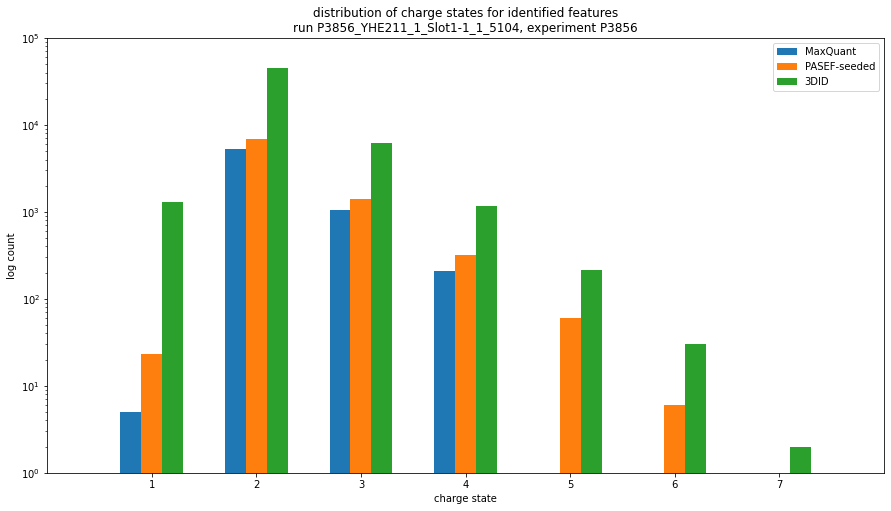

In [68]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

barwidth = 0.2
max_charge = max(idents_mq_df.charge.max(), idents_pasef_df.charge.max(), features_3did_df.charge.max())

pos1 = [x - barwidth for x in range(max_charge+1)]
pos2 = [x + barwidth for x in pos1]
pos3 = [x + (2*barwidth) for x in pos1]

counts = np.bincount(idents_mq_df.charge, minlength=max_charge+1)
ax1.bar(pos1, counts, width=barwidth, align='center', log=True, label='MaxQuant')

counts = np.bincount(idents_pasef_df.charge, minlength=max_charge+1)
ax1.bar(pos2, counts, width=barwidth, align='center', log=True, label='PASEF-seeded')

counts = np.bincount(features_3did_df.charge, minlength=max_charge+1)
ax1.bar(pos3, counts, width=barwidth, align='center', log=True, label='3DID')

ax1.set(xticks=range(1,max_charge+1), xlim=[0, max_charge+1])

plt.xlabel('charge state')
plt.ylabel('log count')
plt.title('distribution of charge states for identified features\nrun {}, experiment {}'.format(run_name, experiment_name))

plt.ylim((1,10**5))

plt.legend()
plt.show()

In [69]:
pasef_3did_df = combined_features_df[(combined_features_df.pasef_feature_id > 0) & (combined_features_df['3did_feature_id'] > 0)]

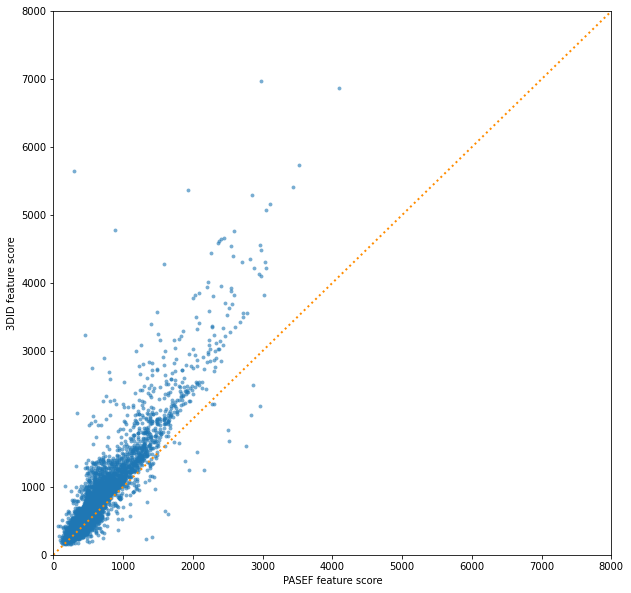

In [70]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)

plt.margins(0.06)
# plt.title('deconvolution score for features identified by PASEF-seeded and features detected by 3DID methods')

ax.scatter(pasef_3did_df.pasef_deconvolution_score, pasef_3did_df['3did_deconvolution_score'], marker='o', lw=0, s=15, alpha=0.6)

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle=':', linewidth=2, color='darkorange')

plt.xlim((-1,8000))
plt.ylim((-1,8000))

plt.xlabel('PASEF feature score')
plt.ylabel('3DID feature score')

plt.show()

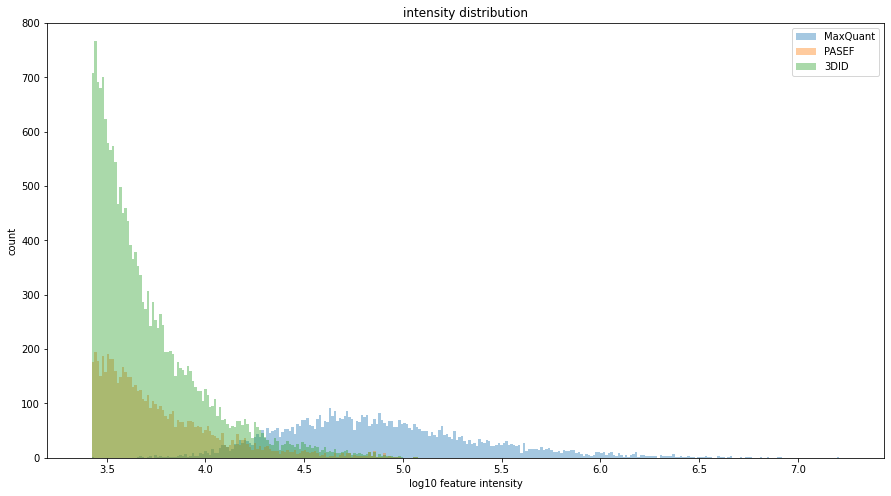

In [71]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('intensity distribution')

bins = 300
hist, bins, _ = plt.hist(combined_features_df[combined_features_df.mq_feature_id > 0].mq_log_intensity, bins=bins, alpha=0.4, label='MaxQuant')
hist, bins, _ = plt.hist(combined_features_df[combined_features_df.pasef_feature_id > 0].pasef_log_intensity, bins=bins, alpha=0.4, label='PASEF')
hist, bins, _ = plt.hist(combined_features_df[combined_features_df['3did_feature_id'] > 0]['3did_log_intensity'], bins=bins, alpha=0.4, label='3DID')

plt.xlabel('log10 feature intensity')
plt.ylabel('count')

# plt.xlim((0,8))
plt.ylim((0,800))

plt.legend()
plt.show()

In [72]:
unique_mq_df = combined_features_df[(combined_features_df.mq_feature_id > 0) & (combined_features_df.pasef_feature_id == 0) & (combined_features_df['3did_feature_id'] == 0)]
unique_pasef_df = combined_features_df[(combined_features_df.mq_feature_id == 0) & (combined_features_df.pasef_feature_id > 0) & (combined_features_df['3did_feature_id'] == 0)]
unique_3did_df = combined_features_df[(combined_features_df.mq_feature_id == 0) & (combined_features_df.pasef_feature_id == 0) & (combined_features_df['3did_feature_id'] > 0)]


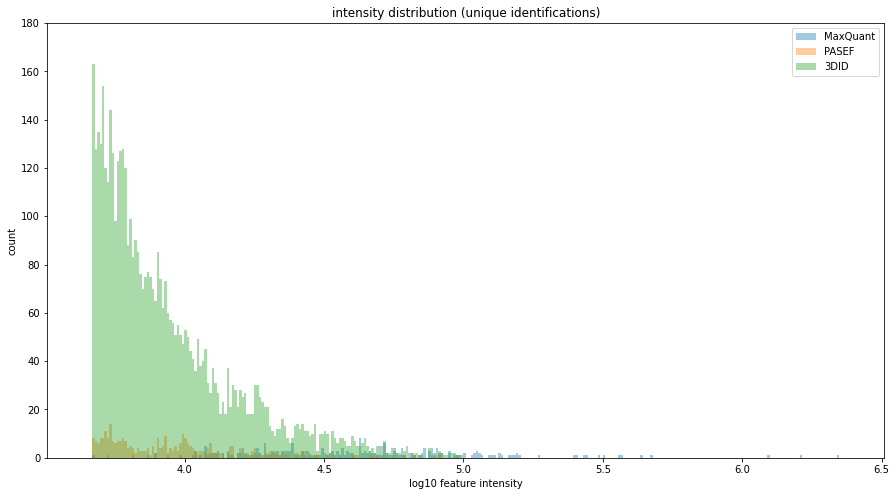

In [73]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('intensity distribution (unique identifications)')

bins = 300
hist, bins, _ = plt.hist(unique_mq_df.mq_log_intensity, bins=bins, alpha=0.4, label='MaxQuant')
hist, bins, _ = plt.hist(unique_pasef_df.pasef_log_intensity, bins=bins, alpha=0.4, label='PASEF')
hist, bins, _ = plt.hist(unique_3did_df['3did_log_intensity'], bins=bins, alpha=0.4, label='3DID')

plt.xlabel('log10 feature intensity')
plt.ylabel('count')

# plt.xlim((0,8))
plt.ylim((0,180))

plt.legend()
plt.show()

#### compare 3did _detected_ features from minvi=2500 and minvi=5000

In [74]:
FEATURES_3DID_MINVI_2500_FILE = '/media/big-ssd/results-P3856-3did/14-jul-minvi-2500/exp-P3856-run-P3856_YHE211_1_Slot1-1_1_5104-features-3did.pkl'
FEATURES_3DID_MINVI_5000_FILE = '/media/big-ssd/results-P3856-3did/14-jul-minvi-5000/exp-P3856-run-P3856_YHE211_1_Slot1-1_1_5104-features-3did.pkl'

In [75]:
# load the features detected by 3DID
with open(FEATURES_3DID_MINVI_5000_FILE, 'rb') as handle:
    d = pickle.load(handle)
minvi_5000_features_df = d['features_df']

In [76]:
# load the features detected by 3DID
with open(FEATURES_3DID_MINVI_2500_FILE, 'rb') as handle:
    d = pickle.load(handle)
minvi_2500_features_df = d['features_df']

In [77]:
minvi_5000_features_df = minvi_5000_features_df[combined_names].copy()
minvi_5000_features_df['minvi'] = '5000'

minvi_2500_features_df = minvi_2500_features_df[combined_names].copy()
minvi_2500_features_df['minvi'] = '2500'

minvi_features_df = pd.concat([minvi_2500_features_df,minvi_5000_features_df], axis=0, sort=False, ignore_index=True)
minvi_features_df['minvi_feature_id'] = minvi_features_df.minvi+'-'+minvi_features_df.feature_id.astype('str')

In [78]:
len(minvi_5000_features_df), len(minvi_2500_features_df)

(55613, 163900)

In [79]:
minvi_features_df.sample(n=5)

,feature_id,charge,monoisotopic_mz,scan_apex,rt_apex,minvi,minvi_feature_id
146881,146881,2,1096.990944,254.0,1788.057237,2500,2500-146881
108955,108955,2,942.467724,295.0,2198.745187,2500,2500-108955
105967,105967,2,948.417712,405.0,1819.289668,2500,2500-105967
36071,36071,2,766.325024,609.0,1656.265408,2500,2500-36071
102434,102434,2,931.440442,413.0,1667.379650,2500,2500-102434


#### compare 3did _identified_ features from minvi=2500 and minvi=5000

In [80]:
FEATURES_3DID_MINVI_2500_FILE = '/media/big-ssd/results-P3856-3did/14-jul-minvi-2500/exp-P3856-run-P3856_YHE211_1_Slot1-1_1_5104-features-3did-dedup.pkl'
FEATURES_3DID_MINVI_5000_FILE = '/media/big-ssd/results-P3856-3did/14-jul-minvi-5000/exp-P3856-run-P3856_YHE211_1_Slot1-1_1_5104-features-3did-dedup.pkl'

In [81]:
# load the features detected by 3DID
with open(FEATURES_3DID_MINVI_5000_FILE, 'rb') as handle:
    d = pickle.load(handle)
minvi_5000_idents_df = d['features_df']

In [82]:
# load the features detected by 3DID
with open(FEATURES_3DID_MINVI_2500_FILE, 'rb') as handle:
    d = pickle.load(handle)
minvi_2500_idents_df = d['features_df']

In [83]:
minvi_5000_idents_df = minvi_5000_idents_df[combined_names].copy()
minvi_5000_idents_df['minvi'] = '5000'

minvi_2500_idents_df = minvi_2500_idents_df[combined_names].copy()
minvi_2500_idents_df['minvi'] = '2500'

minvi_idents_df = pd.concat([minvi_2500_idents_df,minvi_5000_idents_df], axis=0, sort=False, ignore_index=True)
minvi_idents_df['minvi_feature_id'] = minvi_idents_df.minvi+'-'+minvi_idents_df.feature_id.astype('str')

In [84]:
len(minvi_5000_idents_df), len(minvi_2500_idents_df)

(30131, 53621)

In [85]:
minvi_idents_df.sample(n=5)

,feature_id,charge,monoisotopic_mz,scan_apex,rt_apex,minvi,minvi_feature_id
12358,39067,2,763.368873,608.0,1795.471053,2500,2500-39067
42353,40443,2,789.867691,395.0,1716.072224,2500,2500-40443
75493,4428,2,691.829340,748.0,2022.510341,5000,5000-4428
33171,33088,4,762.352887,617.0,2030.976810,2500,2500-33088
82262,49089,2,1060.067356,86.0,2068.548657,5000,5000-49089


#### find the identifications in common between the different minvi values

In [86]:
# set up dup definitions
MZ_TOLERANCE_PERCENT = DUP_MZ_TOLERANCE_PPM * 10**-4
minvi_idents_df['dup_mz'] = minvi_idents_df['monoisotopic_mz']  # shorthand to reduce verbosity
minvi_idents_df['dup_mz_ppm_tolerance'] = minvi_idents_df.dup_mz * MZ_TOLERANCE_PERCENT / 100
minvi_idents_df['dup_mz_lower'] = minvi_idents_df.dup_mz - minvi_idents_df.dup_mz_ppm_tolerance
minvi_idents_df['dup_mz_upper'] = minvi_idents_df.dup_mz + minvi_idents_df.dup_mz_ppm_tolerance
minvi_idents_df['dup_scan_lower'] = minvi_idents_df.scan_apex - DUP_SCAN_TOLERANCE
minvi_idents_df['dup_scan_upper'] = minvi_idents_df.scan_apex + DUP_SCAN_TOLERANCE
minvi_idents_df['dup_rt_lower'] = minvi_idents_df.rt_apex - DUP_RT_TOLERANCE
minvi_idents_df['dup_rt_upper'] = minvi_idents_df.rt_apex + DUP_RT_TOLERANCE

In [87]:
combined_id = 1
combined_features = []
sets_d = {'5000':set(), '2500':set()}
features_processed = set()
for row in minvi_idents_df.itertuples():
    if row.minvi_feature_id not in features_processed:
        df = minvi_idents_df[(row.charge == minvi_idents_df.charge) & (row.dup_mz >= minvi_idents_df.dup_mz_lower) & (row.dup_mz <= minvi_idents_df.dup_mz_upper) & (row.scan_apex >= minvi_idents_df.dup_scan_lower) & (row.scan_apex <= minvi_idents_df.dup_scan_upper) & (row.rt_apex >= minvi_idents_df.dup_rt_lower) & (row.rt_apex <= minvi_idents_df.dup_rt_upper)].copy()
        if len(df) > 0:
            # remove the features that have already been processed
            feature_ids_not_processed = set(df.minvi_feature_id.tolist()) - features_processed
            df = df[(df.minvi_feature_id.isin(feature_ids_not_processed))]
            for minvi in df.minvi.tolist():
                sets_d[minvi].add(combined_id)
            # record the features that have been processed
            features_processed.update(set(df.minvi_feature_id.tolist()))
            # separate the minvi feature ids
            feature_ids = {'5000':0, '2500':0}
            for m in df.minvi_feature_id.tolist():
                minvi = m.split('-')[0]
                feature_id = int(m.split('-')[1])
                feature_ids[minvi] = feature_id
            # store the features that were combined
            combined_features.append({'combined_id':combined_id, 'number_of_minvis':len(df.minvi.unique()), 'minvis':list(df.minvi.unique()), 'minvi_ids':df.minvi_feature_id.tolist(), 'minvi_5000_feature_id':feature_ids['5000'], 'minvi_2500_feature_id':feature_ids['2500']})
            # update the combined feature identifier
            combined_id += 1

In [88]:
combined_features_df = pd.DataFrame(combined_features)
combined_features_df.to_pickle('{}/combined_features_minvi_df.pkl'.format(expanduser('~')))

In [89]:
combined_features_df.sample(n=5)

,combined_id,number_of_minvis,minvis,minvi_ids,minvi_5000_feature_id,minvi_2500_feature_id
53765,53766,1,[5000],[5000-8076],8076,0
28470,28471,1,[2500],[2500-103919],0,103919
53401,53402,1,[2500],[2500-155965],0,155965
43593,43594,1,[2500],[2500-108738],0,108738
16937,16938,1,[2500],[2500-127568],0,127568


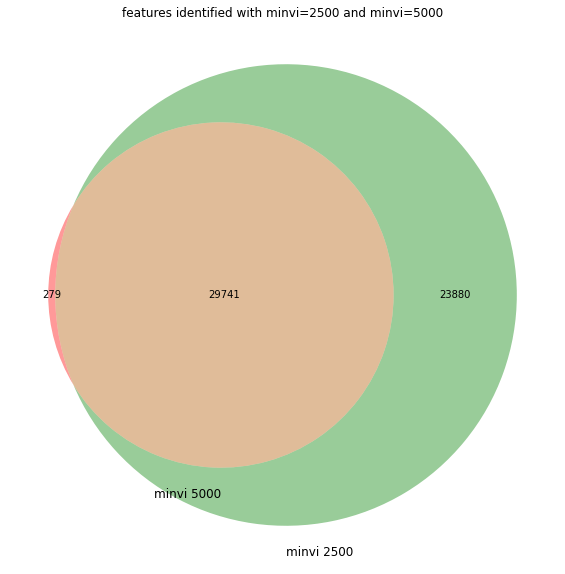

In [90]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

f, ax1 = plt.subplots()
f.set_figheight(10)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('features identified with minvi=2500 and minvi=5000')

venn2([sets_d['5000'],sets_d['2500']], ('minvi 5000','minvi 2500'))

plt.show()